In [5]:
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)



In [6]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
        )

    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        score = tf.squeeze(score, axis=-1)
        alpha = tf.nn.softmax(score, axis=1)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = tf.reduce_sum(inputs * alpha, axis=1)
        return context

In [7]:
ARTIFACTS_DIR="artifacts/"
MODEL_PATH = f"{ARTIFACTS_DIR}bilstm_attention_emotions.keras"

X_test = np.load(f"{ARTIFACTS_DIR}X_test.npy")
y_test = np.load(f"{ARTIFACTS_DIR}y_test.npy")

model = load_model(MODEL_PATH,
    custom_objects={"Attention": Attention})

print("✅ Model and test data loaded successfully")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

✅ Model and test data loaded successfully
X_test shape: (25233, 80)
y_test shape: (25233,)


In [8]:
y_probs = model.predict(X_test, batch_size=256)
y_pred = np.argmax(y_probs, axis=1)

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [9]:
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print(f"✅ Accuracy      : {accuracy:.4f}")
print(f"✅ Macro F1      : {macro_f1:.4f}")
print(f"✅ Weighted F1   : {weighted_f1:.4f}")


✅ Accuracy      : 0.9555
✅ Macro F1      : 0.9327
✅ Weighted F1   : 0.9566


In [10]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

report = classification_report(
    y_test,
    y_pred,
    target_names=labels,
    digits=4
)

print(report)


              precision    recall  f1-score   support

     sadness     0.9941    0.9688    0.9813      7505
         joy     0.9979    0.9395    0.9678      8593
        love     0.8254    0.9990    0.9039      1983
       anger     0.9415    0.9664    0.9538      3481
        fear     0.9371    0.9116    0.9242      2829
    surprise     0.7627    1.0000    0.8654       842

    accuracy                         0.9555     25233
   macro avg     0.9098    0.9642    0.9327     25233
weighted avg     0.9608    0.9555    0.9566     25233



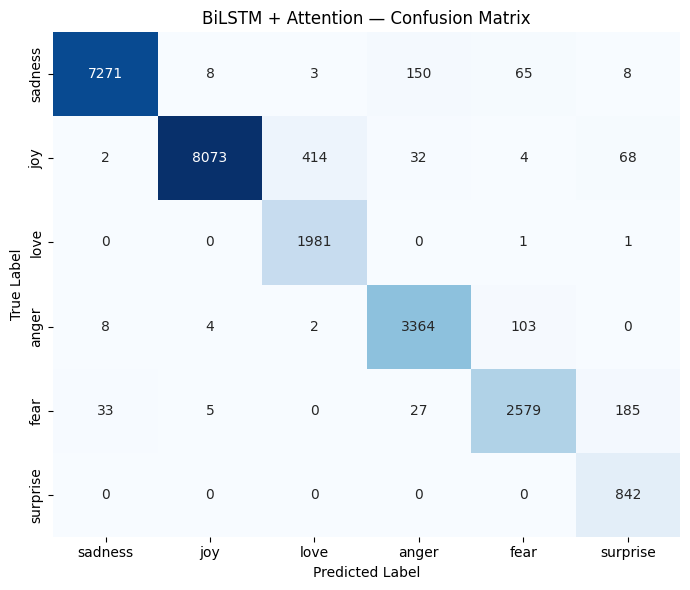

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",cbar=False,
            xticklabels=labels,
            yticklabels=labels)

plt.title("BiLSTM + Attention — Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

plt.savefig("bilstm_confusion_matrix.png", dpi=150)
plt.show()


In [14]:
def benchmark_inference(model, X, batch_size=256):
    start = time.time()
    _ = model.predict(X, batch_size=batch_size, verbose=0)
    end = time.time()
    return end - start


samples_100 = X_test[:100]
samples_1000 = X_test[:1000]

t_100 = benchmark_inference(model, samples_100)
t_1000 = benchmark_inference(model, samples_1000)
t_full = benchmark_inference(model, X_test)

print(f"✅ Inference Time (100 samples):   {t_100:.4f} sec")
print(f"✅ Inference Time (1000 samples):  {t_1000:.4f} sec")
print(f"✅ Inference Time (Full Test):     {t_full:.4f} sec")


✅ Inference Time (100 samples):   0.0981 sec
✅ Inference Time (1000 samples):  0.2013 sec
✅ Inference Time (Full Test):     2.6231 sec


In [16]:
bilstm_metrics = {
    "model": "BiLSTM + Attention",
    "accuracy": float(accuracy),
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "inference_time_sec": {
        "100_samples": t_100,
        "1000_samples": t_1000,
        "full_test": t_full
    },
    "num_test_samples": int(len(X_test)),
    "num_classes": 6,
    "class_labels": labels
}

with open("bilstm_metrics.json", "w") as f:
    json.dump(bilstm_metrics, f, indent=4)

print("✅ Metrics saved to bilstm_metrics.json")


✅ Metrics saved to bilstm_metrics.json
